In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
ticker = 'INDF.JK'
data = yf.download(ticker, start='2015-01-01', end='2023-01-01')
data = data[['Close']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
print(data.head())

Price             Close
Ticker          INDF.JK
Date                   
2015-01-02  5199.977051
2015-01-05  5217.426758
2015-01-06  5147.628418
2015-01-07  5077.831055
2015-01-08  5060.381348


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [9]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

In [11]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\ivanf\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1398
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0080
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0047
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0038
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0039
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0034
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0035
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0043
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0030
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0030
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0030
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0032
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0027
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0036
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0029
Epoc

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

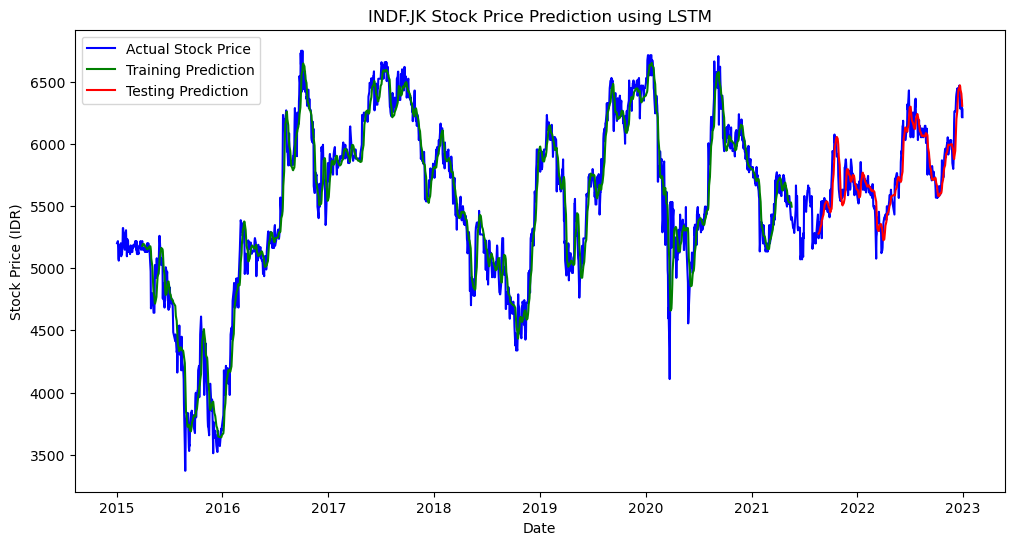

In [23]:
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(12, 6))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Actual Stock Price', color='blue')
plt.plot(data.index, train_plot, label='Training Prediction', color='green')
plt.plot(data.index, test_plot, label='Testing Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.legend()
plt.show()

In [25]:
future_days = 30  
future_inputs = scaled_data[-time_step:].reshape(1, time_step, 1)

future_predictions = []
for _ in range(future_days):
    next_pred = model.predict(future_inputs)[0, 0]
    future_predictions.append(next_pred)
    future_inputs = np.roll(future_inputs, -1, axis=1)
    future_inputs[0, -1, 0] = next_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [27]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [29]:
last_date = data.index[-1]
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, future_days + 1)]

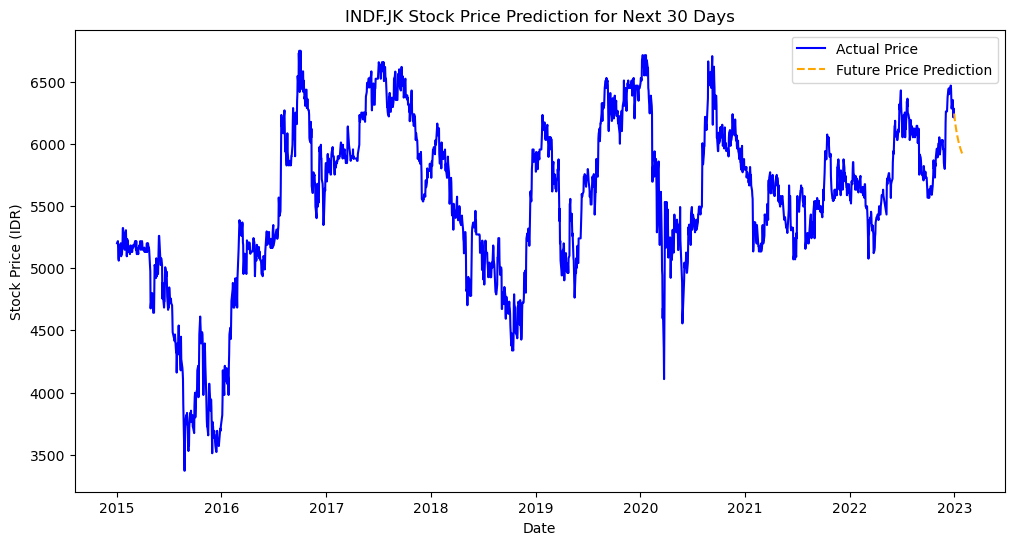

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label="Actual Price", color="blue")
plt.plot(future_dates, future_predictions, label="Future Price Prediction", color="orange", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price (IDR)")
plt.title(f"{ticker} Stock Price Prediction for Next 30 Days")
plt.legend()
plt.show()